 # Task 2: Predict Future Stock Prices (Short-Term)
Objective:
Use historical stock data to predict the next day's closing price using regression algorithms.

 Step 1: Install & Import Libraries

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


Step 2: Download Stock Data

In [3]:
# Download stock data for Apple (AAPL) over the past 2 years
df = yf.download('AAPL', start='2022-01-01', end='2024-12-31')
df.reset_index(inplace=True)

# Show data
df.head()


C:\Users\PC Partner-User1\AppData\Local\Temp\ipykernel_15448\1115036529.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2022-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2022-01-03,178.645676,179.499605,174.425170,174.542947,104487900
1,2022-01-04,176.378342,179.558457,175.809061,179.254190,99310400
2,2022-01-05,171.686707,176.839663,171.411883,176.290017,94537600
3,2022-01-06,168.820648,172.059652,168.467302,169.507706,96904000
4,2022-01-07,168.987518,170.921105,167.868591,169.694211,86709100


Line Plot of Closing Price Over Time

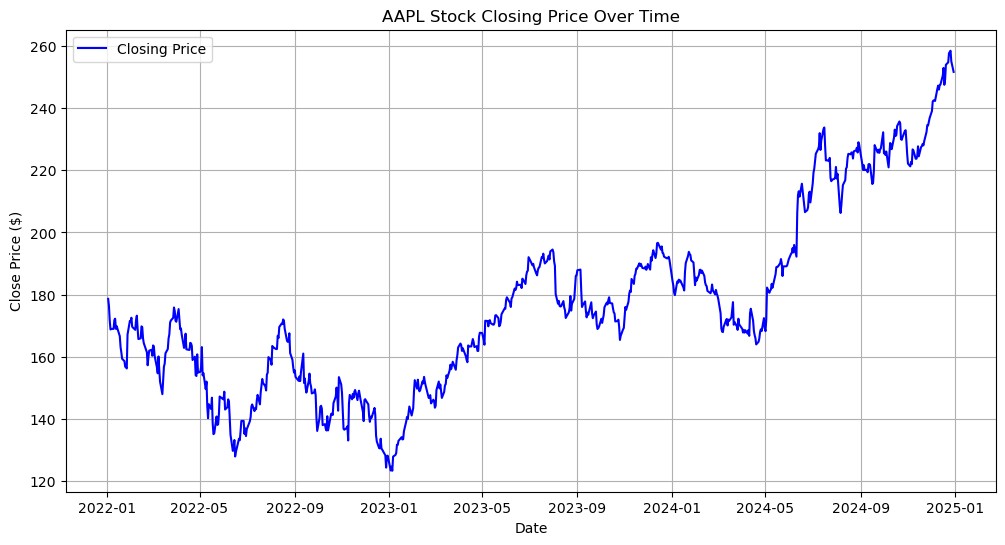

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Closing Price', color='blue')
plt.title('AAPL Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()


 Candlestick Chart (Requires plotly)

In [5]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                                     open=df['Open'],
                                     high=df['High'],
                                     low=df['Low'],
                                     close=df['Close'])])
fig.update_layout(title='Candlestick Chart for AAPL',
                  xaxis_title='Date',
                  yaxis_title='Price ($)')
fig.show()


Correlation Heatmap

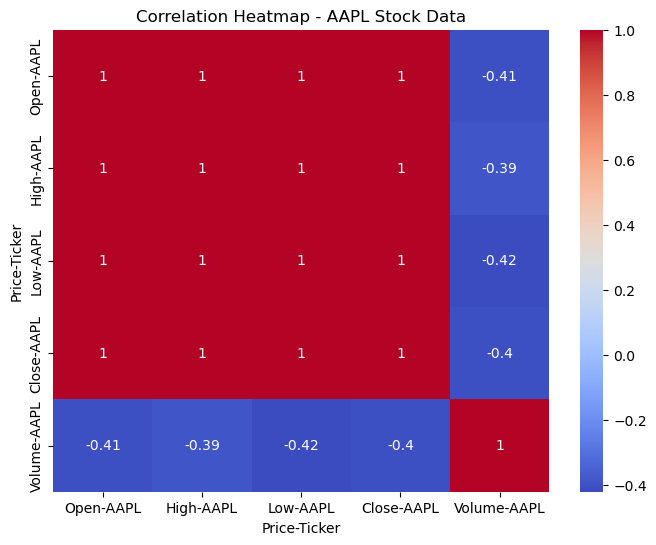

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Open', 'High', 'Low', 'Close', 'Volume']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap - AAPL Stock Data')
plt.show()


Volume Traded Over Time

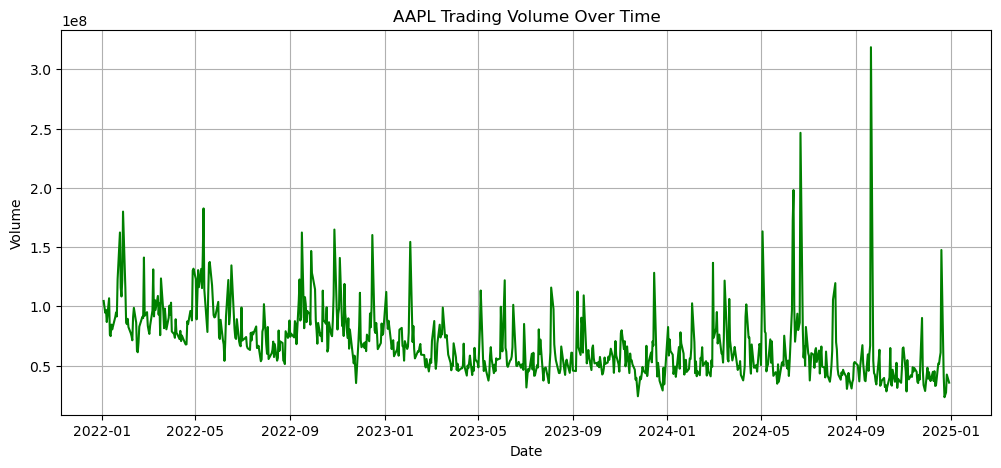

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Volume'], color='green')
plt.title('AAPL Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()


Moving Averages (e.g., 30-day)

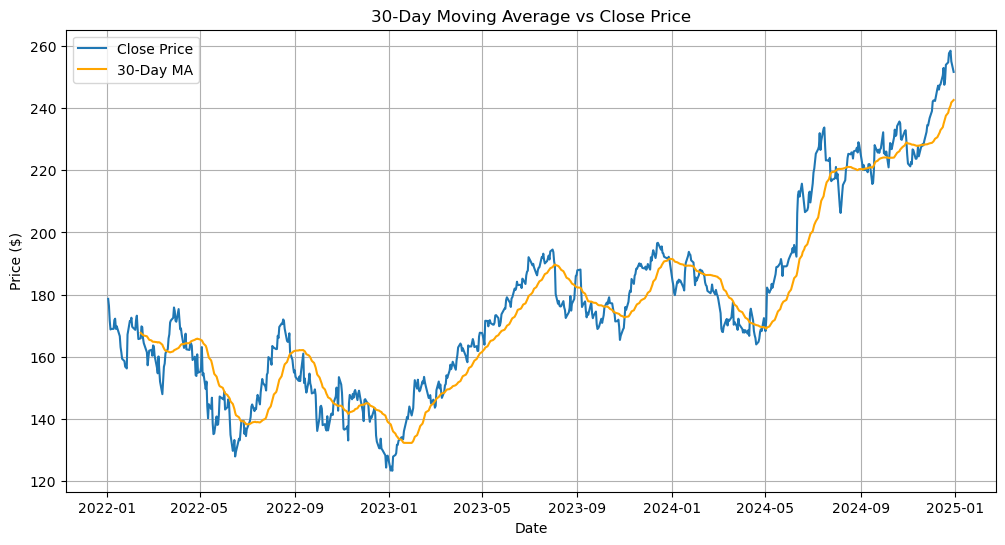

In [7]:
df['30_MA'] = df['Close'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['30_MA'], label='30-Day MA', color='orange')
plt.title('30-Day Moving Average vs Close Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


 Step 3: Prepare the Data

In [8]:
# Create features and target
df['Next_Close'] = df['Close'].shift(-1)

# Drop last row (because target is NaN)
df.dropna(inplace=True)

# Select features and target
features = ['Open', 'High', 'Low', 'Volume']
X = df[features]
y = df['Next_Close']


In [9]:
# Convert Date to datetime and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Feature: Daily Return
df['Daily Return'] = df['Close'].pct_change()

# Feature: Moving Averages
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_21'] = df['Close'].rolling(window=21).mean()

# Feature: Volatility (Rolling Std Dev)
df['Volatility'] = df['Close'].rolling(window=7).std()

# Drop NaN values resulting from rolling windows
df.dropna(inplace=True)

df.head()


Price,Close,High,Low,Open,Volume,30_MA,Next_Close,Daily Return,MA_7,MA_21,Volatility
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,
Date,,,,,,,,,,,
2022-03-15,152.417206,152.888944,147.788385,148.299413,92964300,163.267393,156.839630,0.029678,154.245141,160.298980,3.862594
2022-03-16,156.839630,157.242568,151.798050,154.343411,102300200,162.782633,157.851883,0.029015,154.285849,159.864222,3.892377
2022-03-17,157.851883,158.225339,154.913422,155.876529,75615400,162.291373,161.154007,0.006454,154.732304,159.294686,4.123724
2022-03-18,161.154007,161.645390,157.006732,157.743807,123511700,162.006372,162.529846,0.020919,154.876914,158.893624,4.356231
2022-03-21,162.529846,163.483130,160.200681,160.692064,95811400,161.776731,165.910568,0.008537,155.840025,158.729829,5.245706


In [10]:
features = ['Open', 'High', 'Low', 'Volume', 'Daily Return', 'MA_7', 'MA_21', 'Volatility']
X = df[features]
y = df['Close'].shift(-1)  # Predict the next day's closing price

# Drop the last row with NaN in y
X = X[:-1]
y = y[:-1]


Step 4: Split Dataset

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


 Step 5: Train Model (Random Forest)

In [13]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


e:\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(random_state=42)

 Step 6: Predict and Evaluate

In [14]:
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f" Mean Squared Error: {mse:.2f}")
print(f" R² Score: {r2:.2f}")


 Mean Squared Error: 8.88
 R² Score: 0.99


 Step 7: Visualize Predictions vs Actual

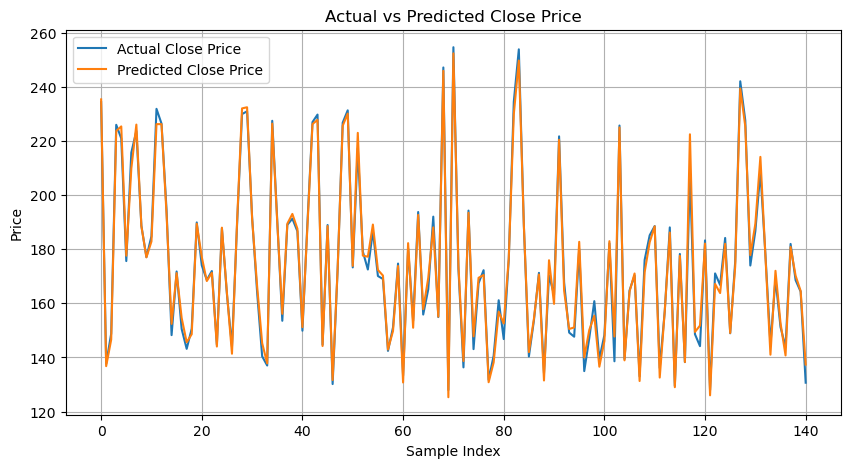

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Close Price')
plt.plot(y_pred, label='Predicted Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


 Save Model to pkl File

In [22]:
import joblib

# Save model
joblib.dump(model, 'stock_price_model.pkl')

# Optional: Save scaler too for consistent future preprocessing
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [23]:
# Load model and scaler
loaded_model = joblib.load('stock_price_model.pkl')
loaded_scaler = joblib.load('scaler.pkl')

# Prepare new input data
X_new_scaled = loaded_scaler.transform(X_test)  # or any new data

# Predict
y_pred = loaded_model.predict(X_new_scaled)


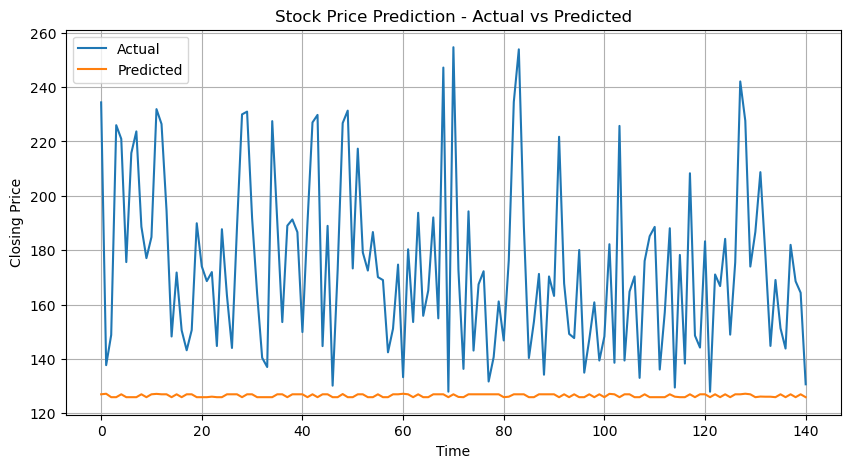

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title("Stock Price Prediction - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.grid(True)
plt.show()


Predication

In [27]:
import pandas as pd
import joblib

# Step 1: Load trained model and scaler
model = joblib.load('stock_price_model.pkl')
scaler = joblib.load('scaler.pkl')

# Step 2: Create input with all 8 required features
new_data = pd.DataFrame([{
    'Open': 170.12,
    'High': 172.50,
    'Low': 169.80,
    'Volume': 68903400,
    'Daily Return': 0.0025,
    'MA_7': 171.0,
    'MA_21': 169.5,
    'Volatility': 0.018
}])

# Step 3: Scale the input using the same scaler
new_data_scaled = scaler.transform(new_data)

# Step 4: Make prediction
predicted_close = model.predict(new_data_scaled)

# Step 5: Output
print(f" Predicted Next Close Price: ${predicted_close[0]:.2f}")
# Step 6: Visualize the prediction

 Predicted Next Close Price: $127.00


e:\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



In [28]:
# Convert to NumPy before scaling
new_data_scaled = scaler.transform(new_data.values)


In [30]:
# Step 3 (Fixed): Scale the input safely
new_data_scaled = scaler.transform(new_data.values)

# Step 4: Make prediction
predicted_close = model.predict(new_data_scaled)
print(f" Predicted Next Close Price: ${predicted_close[0]:.2f}")


 Predicted Next Close Price: $127.00
